In [ ]:
import metmhn.simulations as simul
import metmhn.Utilityfunctions as utils
import metmhn.regularized_optimization as regopt
import numpy as np
import pandas as pd

import jax as jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)


In [ ]:
rng = np.random.default_rng(seed=42)
n_sim = int(1e04)

In [ ]:
params = pd.read_csv("../results/paad/coupled_only_25m_5cnvs_01.csv", index_col=0)
fd_effects = params.iloc[0,:].to_numpy()
sd_effects = params.iloc[1, :].to_numpy()
th_learned = params.iloc[2:,:].to_numpy()
events=params.columns
n_th = fd_effects.shape[0] - 1
dat, _ = simul.simulate_dat(th_learned, fd_effects, sd_effects, 10000, rng)
dat = np.delete(dat, np.sum(dat, axis=1)==0, axis=0)
pt_only = dat[dat[:,-1]==0, :]
mt_coupled = dat[dat[:,-1]==1, :]
m_p_cor = mt_coupled.shape[0]/dat.shape[0]

In [ ]:
sizes = 50 * np.array([0., .5, 1, 2.5, 5])
pt_inds = rng.integers(0, pt_only.shape[0], size=200)
dat_prim_nomet = jnp.array(pt_only[pt_inds, :])

c_c_inds = rng.integers(0, mt_coupled.shape[0], size=50)
dat_coupled = jnp.array(mt_coupled[c_c_inds, :])

res = np.zeros(((n_th)*(n_th+2), 10))
for i in range(sizes.shape[0]):
    n_single = int(sizes[i])
    mt_only_inds = rng.integers(0, mt_coupled.shape[0], size=n_single)
    dat_met_only = jnp.array(mt_coupled[mt_only_inds,:].copy())
    
    pt_only_inds = rng.integers(0, mt_coupled.shape[0], size=n_single)
    dat_prim_met = jnp.array(mt_coupled[pt_only_inds,:].copy())
    
    full = jnp.vstack((dat_coupled, dat_met_only, dat_prim_met, dat_prim_nomet))
    n_full = full.shape[0]
    th_init, fd_init, sd_init = utils.indep(full, n_full)
    th, fd, sd = regopt.learn_mhn(th_init, fd_init, sd_init, dat_prim_nomet, dat_prim_met, 
                                  dat_met_only, dat_coupled, m_p_cor, 0.01)
    res[:,i] = np.concatenate((th.flatten(), fd, sd))

In [ ]:
pt_inds = rng.integers(0, pt_only.shape[0], size=200)
dat_prim_nomet = jnp.array(pt_only[pt_inds, :])

c_c_inds = rng.integers(0, mt_coupled.shape[0], size=50)
dat_coupled = jnp.array(mt_coupled[c_c_inds, :])

mt_only_inds = rng.integers(0, mt_coupled.shape[0], size=250)
dat_met_only = jnp.array(mt_coupled[mt_only_inds,:].copy())
    
pt_only_inds = rng.integers(0, mt_coupled.shape[0], size=250)
dat_prim_met = jnp.array(mt_coupled[pt_only_inds,:].copy())

In [27]:
n_tot = n_th + 1
arr = dat_coupled * np.array([1,2]*n_th+[1])
arr = arr @ (np.diag([1,0]*n_th+[1]) + np.diag([1,0]*n_th, -1))
counts = np.zeros((6, n_tot))
for i in range(0,2*n_tot,2):
    i_h = int(i/2)
    for j in range(1,4):
        counts[j-1, i_h] = np.count_nonzero(arr[:,i]==j)/dat_coupled.shape[0]
    counts[3, i_h] = np.sum(dat_prim_nomet[:, i], axis=0)/dat_prim_nomet.shape[0]
    counts[4, i_h] = (np.sum(dat_prim_met[:, i], axis=0))/dat_prim_met.shape[0]
    counts[5, i_h] = (np.sum(dat_met_only[:, i+1], axis=0))/dat_met_only.shape[0]

labels = [["Coupled ("+str(dat_coupled.shape[0])+")"]*3 +\
          ["NM ("+str(dat_prim_nomet.shape[0])+")"] +\
          ["EM-PT ("+str(dat_prim_met.shape[0])+")"] +\
          ["EM-MT ("+str(dat_met_only.shape[0])+")"],
          ["PT-Private", "MT-Private", "Shared"] + ["Present"]*3]

#events = ["A", "B", "C", "D", "E", "F", "G", "H", "Seeding"]       
inds =  pd.MultiIndex.from_tuples(list(zip(*labels)))
counts = pd.DataFrame(np.around(counts, 2), columns=events, index=inds).T
counts

Coupled (50)                   NM (200) EM-PT (250)  \
                  PT-Private MT-Private Shared  Present     Present   
TP53 (M)                0.12       0.12   0.34     0.38        0.46   
TERT/5p (Amp)           0.04       0.16   0.18     0.28        0.33   
MCL1/1q (Amp)           0.02       0.16   0.26     0.30        0.35   
KRAS (M)                0.08       0.06   0.22     0.40        0.34   
EGFR (M)                0.10       0.06   0.18     0.37        0.31   
TP53/17p (Del)          0.04       0.16   0.10     0.16        0.14   
STK11/19p (Del)         0.02       0.14   0.12     0.16        0.18   
STK11 (M)               0.04       0.02   0.14     0.16        0.20   
KRAS/12p (Amp)          0.00       0.10   0.04     0.04        0.10   
KEAP1 (M)               0.06       0.10   0.08     0.06        0.11   
SMARCA4 (M)             0.02       0.02   0.12     0.04        0.07   
ATM (M)                 0.00       0.00   0.08     0.06        0.08   
NF1 (M)                 0.02       0.02   0.00     0.10        0.06   
PTPRD (M)               0.00       0.02   0.04     0.05        0.05   
PTPRT (M)               0.00       0.02   0.02     0.04        0.06   
ARID1A (M)              0.00       0.08   0.00     0.02        0.04   
PIK3CA (M)              0.00       0.04   0.04     0.07        0.06   
BRAF (M)                0.02       0.02   0.08     0.04        0.06   
SETD2 (M)               0.02       0.08   0.06     0.06        0.05   
EPHA3 (M)               0.02       0.00   0.02     0.04        0.06   
FAT1 (M)                0.00       0.02   0.02     0.04        0.04   
Seeding                 1.00       0.00   0.00     0.00        1.00   

                EM-MT (250)  
                    Present  
TP53 (M)               0.52  
TERT/5p (Amp)          0.49  
MCL1/1q (Amp)          0.44  
KRAS (M)               0.28  
EGFR (M)               0.29  
TP53/17p (Del)         0.26  
STK11/19p (Del)        0.26  
STK11 (M)              0.15  
KRAS/12p (Amp)         0.20  
KEAP1 (M)              0.14  
SMARCA4 (M)            0.07  
ATM (M)                0.07  
NF1 (M)                0.05  
PTPRD (M)              0.03  
PTPRT (M)              0.06  
ARID1A (M)             0.05  
PIK3CA (M)             0.05  
BRAF (M)               0.05  
SETD2 (M)              0.03  
EPHA3 (M)              0.02  
FAT1 (M)               0.06  
Seeding                1.00

In [33]:
full = jnp.vstack((dat_coupled, dat_met_only, dat_prim_met, dat_prim_nomet))
n_full = full.shape[0]
th_init, fd_init, sd_init = utils.indep(full, n_full)
th, fd, sd = regopt.learn_mhn(th_init, fd_init, sd_init, dat_prim_nomet, dat_prim_met, 
                                dat_met_only, dat_coupled, m_p_cor, 1/750)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          528     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.04013D+00    |proj g|=  2.67176D-01


 This problem is unconstrained.



At iterate    1    f=  8.63507D+00    |proj g|=  7.79790D-02

At iterate    2    f=  8.53374D+00    |proj g|=  6.31029D-02

At iterate    3    f=  8.26381D+00    |proj g|=  1.05690D-01

At iterate    4    f=  8.10914D+00    |proj g|=  1.34216D-01

At iterate    5    f=  8.02835D+00    |proj g|=  7.14399D-02

At iterate    6    f=  7.97718D+00    |proj g|=  2.75166D-02

At iterate    7    f=  7.92141D+00    |proj g|=  3.37899D-02

At iterate    8    f=  7.88631D+00    |proj g|=  2.31739D-02

At iterate    9    f=  7.83677D+00    |proj g|=  2.72710D-02

At iterate   10    f=  7.82289D+00    |proj g|=  4.63099D-02

At iterate   11    f=  7.80883D+00    |proj g|=  1.96215D-02

At iterate   12    f=  7.78804D+00    |proj g|=  1.19320D-02

At iterate   13    f=  7.77339D+00    |proj g|=  2.55667D-02

At iterate   14    f=  7.76259D+00    |proj g|=  2.33972D-02

At iterate   15    f=  7.75121D+00    |proj g|=  9.67150D-03

At iterate   16    f=  7.74346D+00    |proj g|=  9.72069D-03

At iter

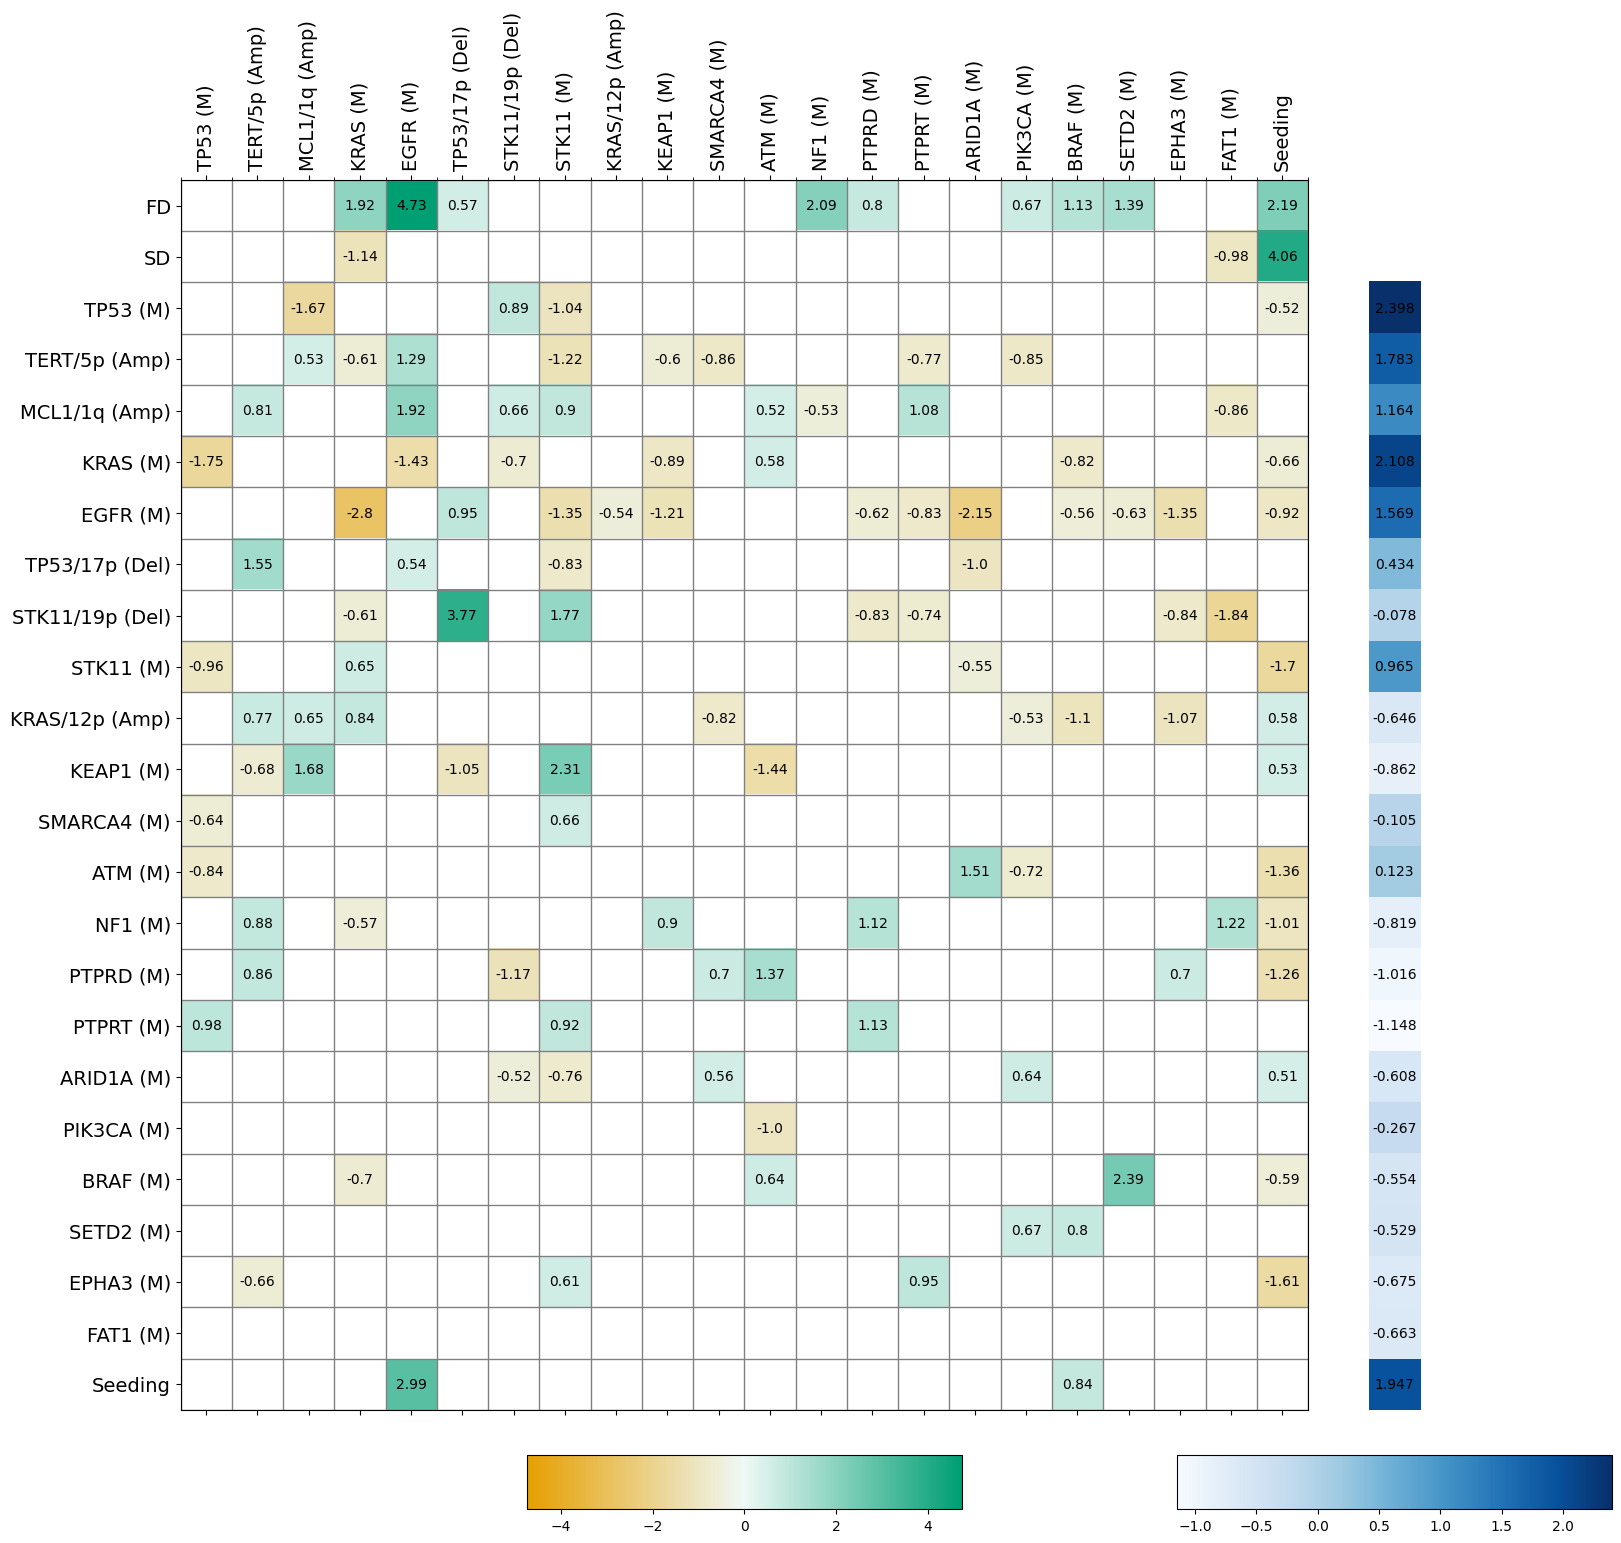

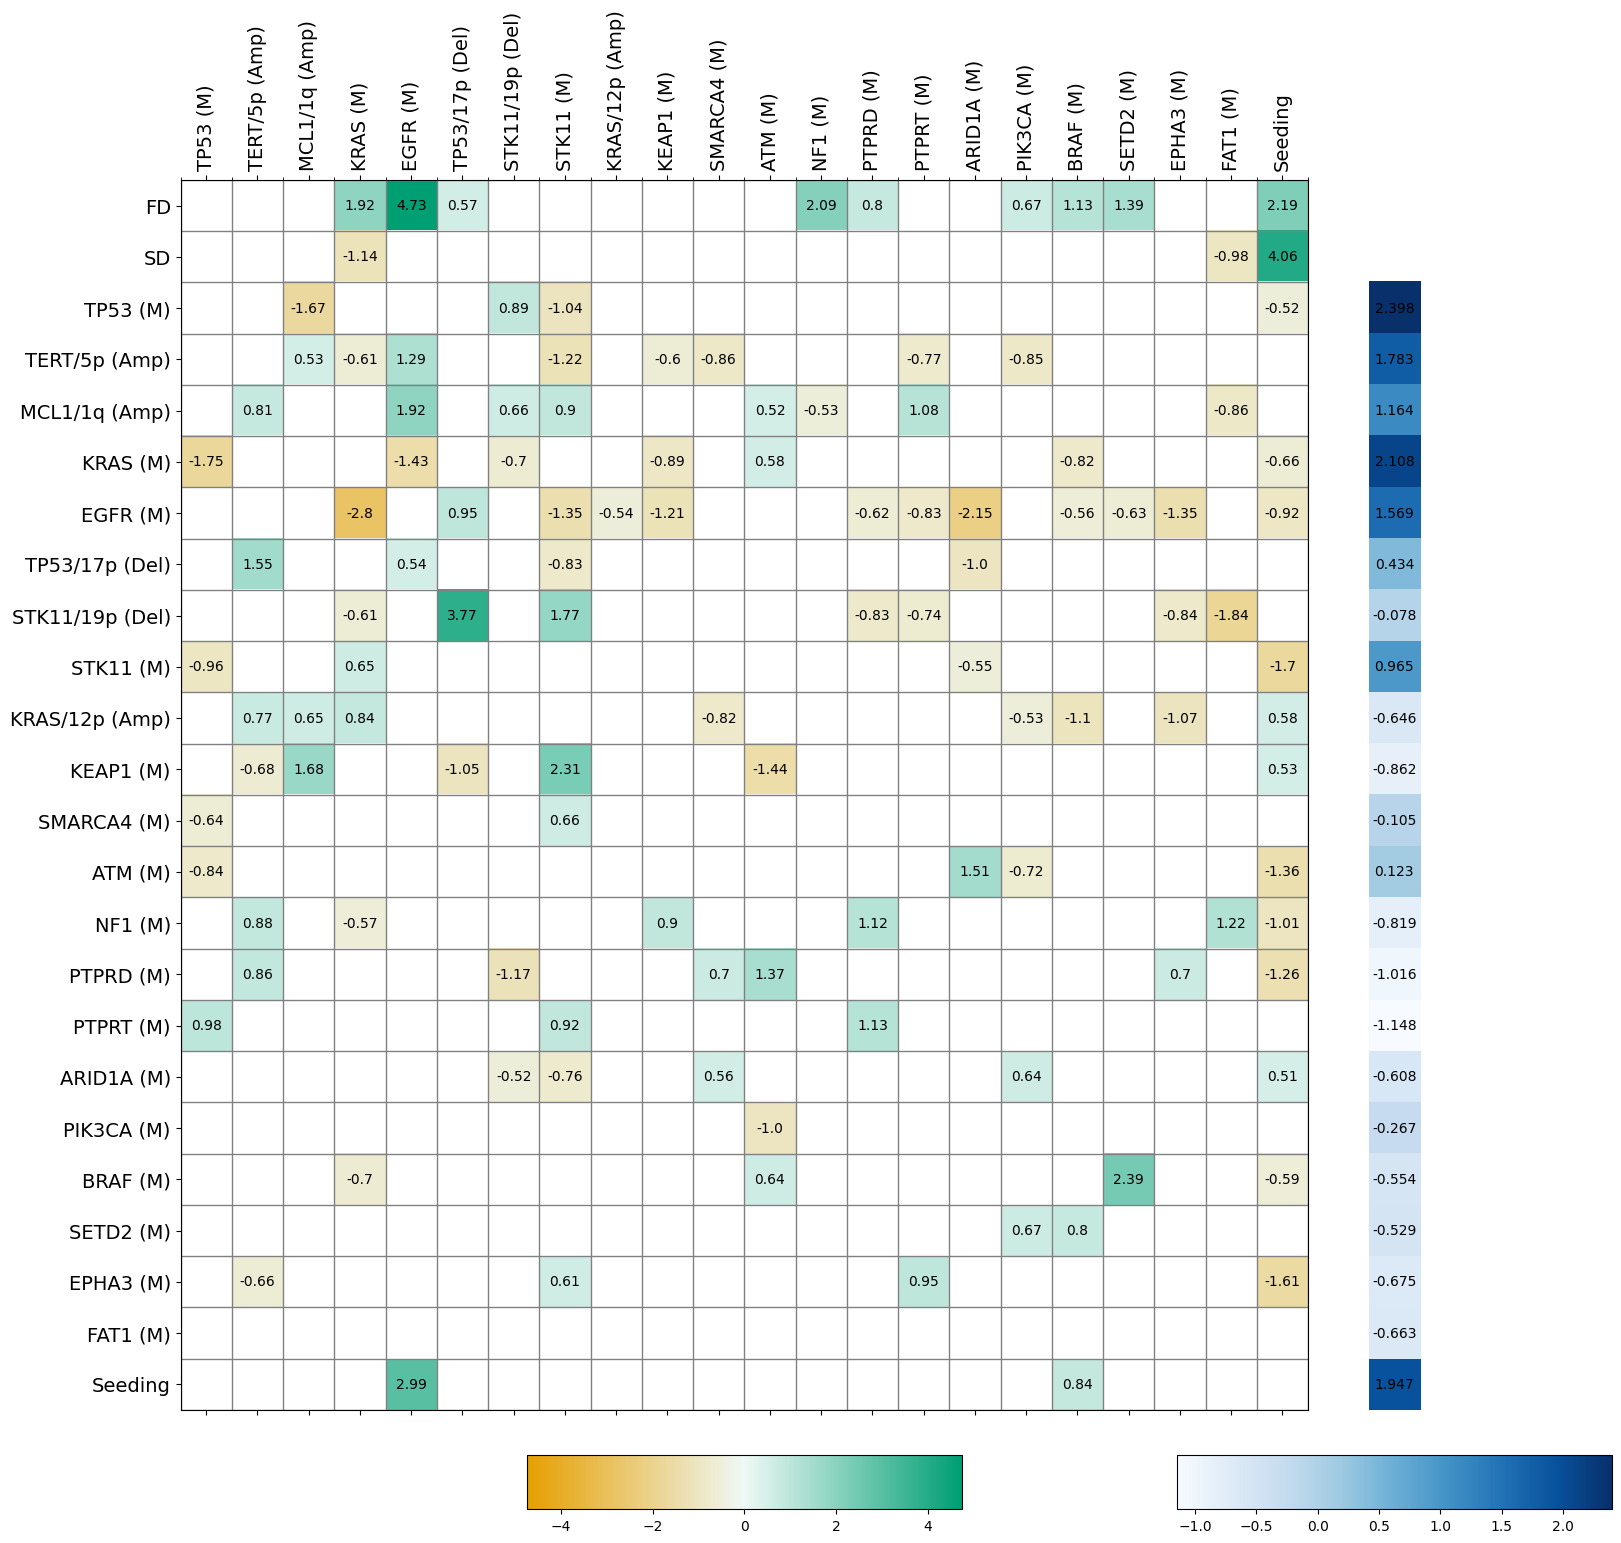

In [36]:
#th_1 = np.round(res[:(n_th)**2, 0].reshape((n_th, n_th)),2)
#fd_effects = res[(n_th)**2:n_th**2+n_th, 1].reshape((1, -1))
#sd_effects = res[n_th**2+n_th:, 1].reshape((1,-1))
th_plot = np.row_stack((fd.reshape((1,-1)), 
                    sd.reshape((1,-1)), 
                    th))
utils.plot_theta(th_plot, events, 0.5)

In [35]:
dat, _ = simul.simulate_dat(th, fd, sd, 10000, rng)
res_no_met = dat[dat[:,-1]==0, :]
res_coupled = dat[dat[:,-1]==1, :]
n_mod = n_th
arr = res_coupled * np.array([1,2]*n_mod+[1])
arr = arr @ (np.diag([1,0]*n_mod+[1]) + np.diag([1,0]*n_mod, -1))
counts = np.zeros((4, n_tot))
for i in range(0,2*n_tot,2):
    i_h = int(i/2)
    for j in range(1,4):
        counts[j-1, i_h] = np.count_nonzero(arr[:,i]==j)/res_coupled.shape[0]
        counts[3, i_h] = np.sum(res_no_met[:, i], axis=0)/res_no_met.shape[0]

labels = [["Coupled ("+str(res_coupled.shape[0])+")"]*3 +\
          ["NM ("+str(res_no_met.shape[0])+")"],
          ["PT-Private", "MT-Private", "Shared"] + ["Present"]]
       
inds =  pd.MultiIndex.from_tuples(list(zip(*labels)))
iwas = pd.DataFrame(np.around(counts, 5), columns=events, index=labels).T
#iwas.to_latex("luad_samples.tex")
iwas

Coupled (6640)                     NM (3360)
                    PT-Private MT-Private   Shared   Present
TP53 (M)               0.06581    0.10813  0.40120   0.39762
TERT/5p (Amp)          0.04955    0.18780  0.27620   0.25804
MCL1/1q (Amp)          0.07289    0.20843  0.26461   0.29018
KRAS (M)               0.07937    0.06581  0.24307   0.38542
EGFR (M)               0.09307    0.05723  0.22289   0.37619
TP53/17p (Del)         0.03795    0.14940  0.10648   0.16071
STK11/19p (Del)        0.04458    0.13268  0.13163   0.15417
STK11 (M)              0.04623    0.02410  0.14127   0.15625
KRAS/12p (Amp)         0.01852    0.13148  0.06039   0.04970
KEAP1 (M)              0.01883    0.09548  0.07756   0.06548
SMARCA4 (M)            0.01943    0.02741  0.05271   0.04792
ATM (M)                0.02289    0.01446  0.06009   0.05893
NF1 (M)                0.02726    0.02756  0.02319   0.09911
PTPRD (M)              0.01777    0.01310  0.02907   0.05298
PTPRT (M)              0.01762    0.03253  0.03614   0.04077
ARID1A (M)             0.00813    0.03313  0.02575   0.01994
PIK3CA (M)             0.01762    0.02967  0.03584   0.05952
BRAF (M)               0.01672    0.02214  0.03735   0.03631
SETD2 (M)              0.01386    0.03057  0.02229   0.05744
EPHA3 (M)              0.01491    0.00873  0.03178   0.03780
FAT1 (M)               0.01310    0.02846  0.02696   0.03512
Seeding                1.00000    0.00000  0.00000   0.00000

In [ ]:
th_2 = np.round(res[:(n_th)**2, 4].reshape((n_th, n_th)),2)
fd_effects = res[(n_th)**2:n_th**2+n_th, 4].reshape((1, -1))
sd_effects = res[n_th**2+n_th:, 4].reshape((1,-1))
th_plot = np.row_stack((fd_effects.reshape((1,-1)), 
                    sd_effects.reshape((1,-1)), 
                    th_2))
utils.plot_theta(th_plot, events, 0.1)

In [ ]:
th = np.round(th_learned,2)
th_plot = np.row_stack((fd_effects.reshape((1,-1)), 
                    sd_effects.reshape((1,-1)), 
                    th))
utils.plot_theta(th_plot, events, 0.1)